# 6 Object Detection
- Template matching
- Corner detection
- Edge Detection
- Grid detection
- Contour detection
- Feature matching: most advanced method
- Watershed
- Facial and eye detection with Haar cascades
- Project: blurring license plates

## 6.7 Watershed Segmentation

Watershed = Drainage Divide = Geographical area that channels rainfall and water. These watershed areas are then topographically segmented.

Images are treated as topography: brightness is height; high values are peaks, low values valleys.

Image is filled with "water" in the images and segments appear, which are delimited with boundaries. As the "water" increases, if no boundaries set, everything would merge.

Typical use cases:
- Coins touching each other on image: segment them
- Foreground-background segmentation
- Segment elements in the scene, even in 3D space

We can manually set the **seeds** to influence the segmentation.

The following topics are analyzed in custom sections:
- 6.7.1 First Trial: Blob Analysis + Contours
- 6.7.2 Watershed Algorithm
- 6.7.3 Watershed Algorithm with Manually Selected Seeds

### 6.7.1 First Trial: Blob Analysis + Contours

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

In [30]:
sep_coins = cv2.imread('../../data/pennies.jpg')
sep_coins_org = sep_coins.copy()

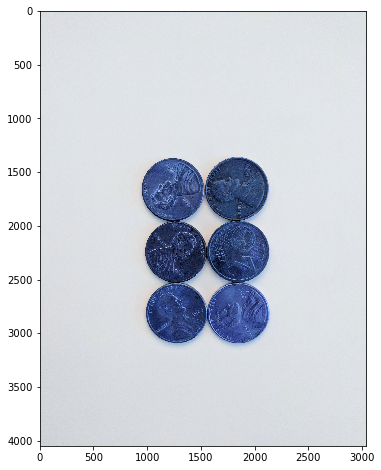

In [31]:
# For the human eye it's easy to distinguish each coin
# But for the computer, it's difficult to find the coin boundaries
display(sep_coins)

In [32]:
# Median blur
# Grayscale
# Binary threshold
# Find contours

In [33]:
sep_coins = cv2.medianBlur(sep_coins,25)

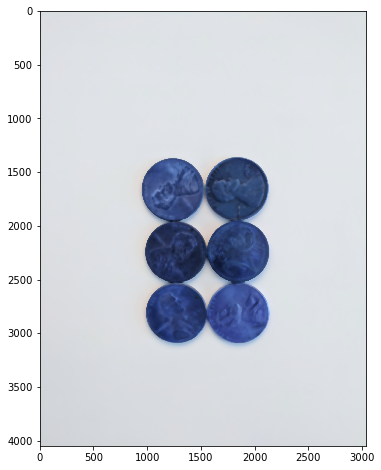

In [34]:
display(sep_coins)

In [35]:
sep_coins = cv2.cvtColor(sep_coins, cv2.COLOR_BGR2GRAY)

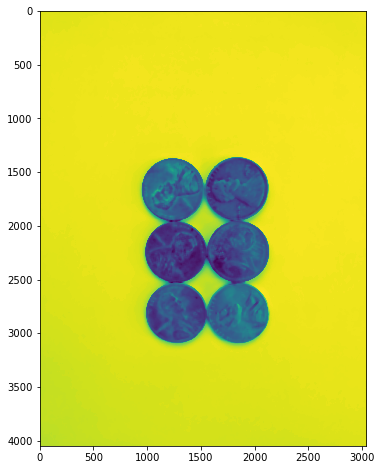

In [36]:
display(sep_coins)

In [37]:
ret, sep_thres = cv2.threshold(sep_coins, 160, 255, cv2.THRESH_BINARY_INV)

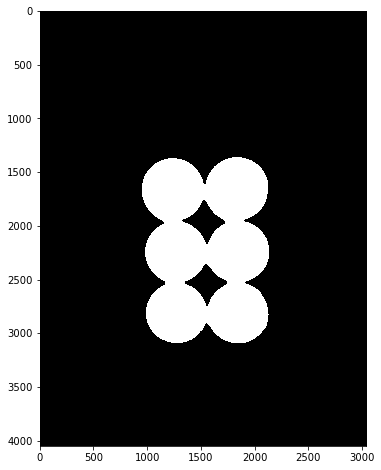

In [38]:
display(sep_thres,cmap='gray')

In [39]:
image,contours,hierarchy = cv2.findContours(sep_thres.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [43]:
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins_org, contours, i, (255,0,0), 10)

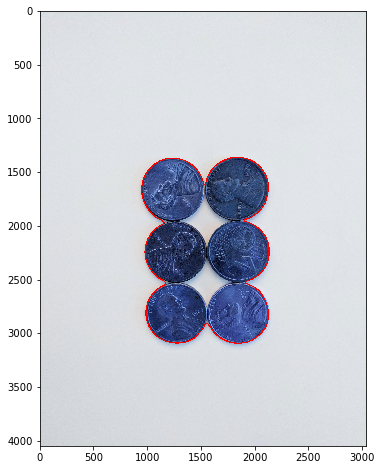

In [44]:
display(sep_coins_org)

**IMPORTANT NOTE**: In order to differentiate the outer/external contours of each coin, we could apply erosion + dilation, but: when eroded the diameter is decreased and when dilated again, blobs overlap/merge, since OpenCV does not distinguish connected blobs, unlike Halcon.

### 6.7.2 Watershed Algorithm

In [45]:
sep_coins = cv2.imread('../../data/pennies.jpg')
sep_coins_org = sep_coins.copy()

In [46]:
sep_coins = cv2.medianBlur(sep_coins,35)

In [48]:
gray = cv2.cvtColor(sep_coins, cv2.COLOR_BGR2GRAY)

In [55]:
# There is a thresholding method after Otsu
# It works very well distinguishing filtering noise values
# In particular, it works really well in combination with Watershed
# Otsu's method:
# - it is equivalent to k-means (k=2) with which pixels are assigned to foreground/background
# - inter-class variance is plotted across pixel intensity spectrum: threshold is where maximum
# - see: https://en.wikipedia.org/wiki/Otsu%27s_method
# Otsu's method must be added to type and [thres,max] is set to [0,255] to comprise the whole intensity spectrum
ret, thres = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

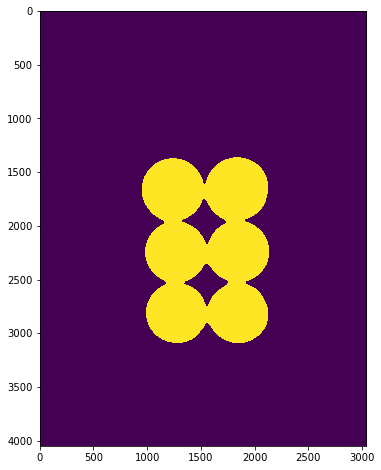

In [54]:
display(thres)

In [62]:
# If we don't apply Otsu's method, we usually need to remove noise, eg, with openning
# If we have noise even after applying Otsu, we need to denoise the image!
kernel = np.ones((3,3), np.uint8)

In [63]:
opening = cv2.morphologyEx(thres, cv2.MORPH_OPEN, kernel, iterations=2)

In [86]:
sure_bg = cv2.dilate(opening,kernel,iterations=3)

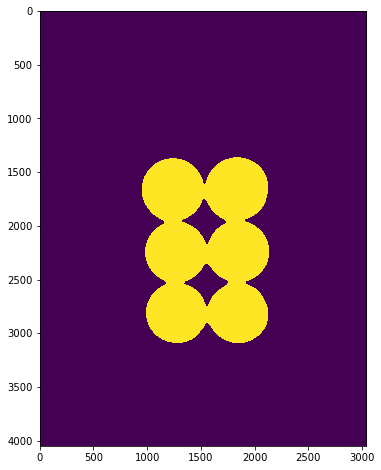

In [87]:
# No changes in our case, because we have already a denoised image
display(opening)

In [88]:
# Distance Transform
# See: https://en.wikipedia.org/wiki/Distance_transform
# The distance transform computes discrete distance values for binary pixelmaps
# distType: DIST_L2 (continuous); L1 would be layered, I guess
# kernel size: 5
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

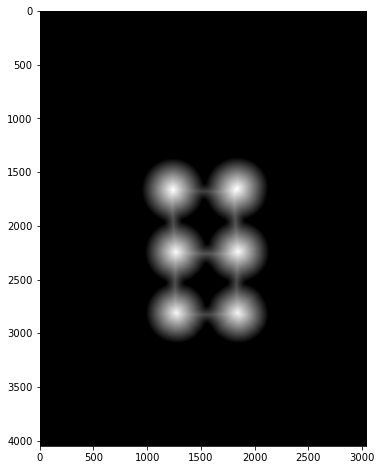

In [89]:
display(dist_transform, cmap='gray')

The key idea is that we apply `threshold` on the distance map, so the centers of the blobs are clearcly distinguishable. Then, **we use the centers as the seeds for the watershed algorithm**.

In [90]:
# Usually, values higher than 70% of the max intensity are taken
# The result is sure in the foreground
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, cv2.THRESH_BINARY)

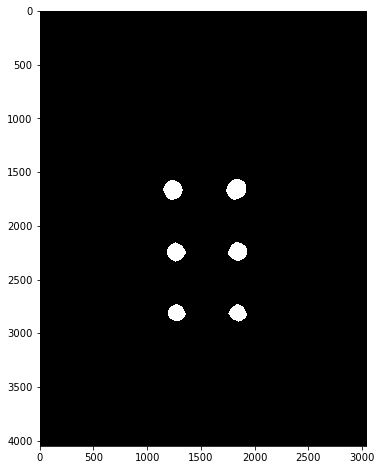

In [91]:
display(sure_fg, cmap = 'gray')

In [92]:
sure_fg = np.uint8(sure_fg) # cast it to be an int

In [98]:
# We substract the sure foreground from the background
# The result is the region that must be segmented correctly
# The sure foreground are the seeds for the watershed algorithm
unknown = cv2.subtract(sure_bg, sure_fg)

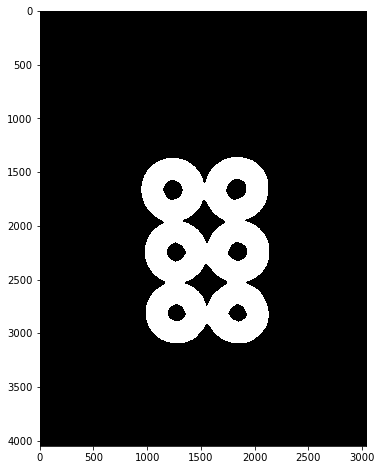

In [132]:
display(unknown, cmap='gray')

In [139]:
# We create labeled markers for the 6 sure foreground dots
# cv2.connectedComponents() creates a distinct label for each of the disjoint blobs
# and creates a mask with these labels for teh pixels
ret, markers = cv2.connectedComponents(sure_fg)

In [140]:
# markers has the same shape/size as the image
markers.shape

(4048, 3036)

In [141]:
sure_fg.shape

(4048, 3036)

In [142]:
markers

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [143]:
markers.max()

6

In [144]:
# All values increased a unit
markers = markers + 1

In [151]:
# All pixels of the unknown region (those that are white/selected in unknown image) are set to 0 (black)
markers[unknown==255] = 0

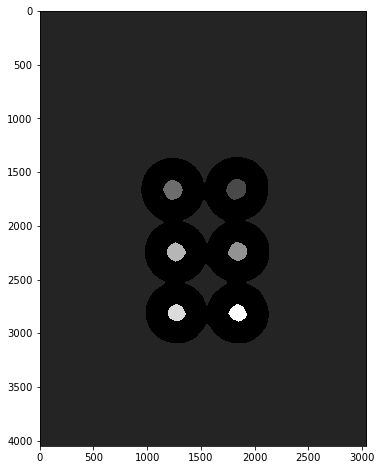

In [152]:
# Note that the grayvalue of the seed points increases from one point to the other
# The black area is the unknows region
# The seeds for the watershed algorithm have label values
display(markers, cmap='gray')

In [154]:
# We pass the image + markers mask
makers = cv2.watershed(sep_coins, markers)

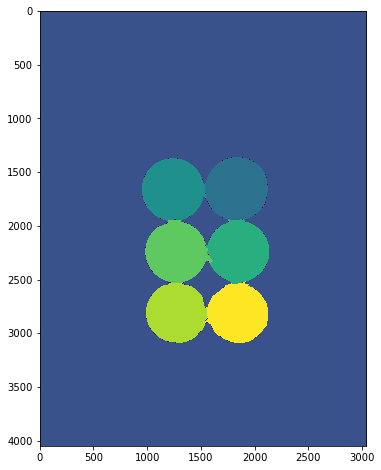

In [155]:
display(makers)

In [156]:
# We can now find the contours of the segmented blobs = markers
image,contours,hierarchy = cv2.findContours(makers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [159]:
sep_coins = cv2.imread('../../data/pennies.jpg')
sep_coins_org = sep_coins.copy()
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins_org, contours, i, (255,0,0), 10)

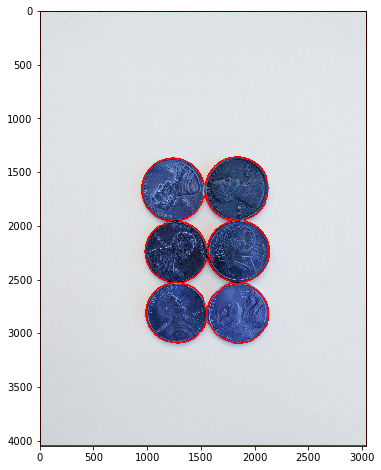

In [160]:
display(sep_coins_org)

### 6.7.3 Watershed Algorithm with Manually Selected Seeds

We basically click on the image to select seeds and the algorithm segments the image accordingly.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
road = cv2.imread('../../data/road_image.jpg')

In [3]:
road_copy = np.copy(road)

In [4]:
#plt.imshow(road)

In [5]:
road.shape

(600, 800, 3)

In [6]:
marker_image = np.zeros(road.shape[:2],dtype=np.int32)

In [7]:
segments = np.zeros(road.shape, dtype=np.uint8)

In [8]:
# Matplotlib: color maps reference
# https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
# Qualitative colormaps: tab10 is a nice one

In [9]:
from matplotlib import cm

In [10]:
# 0-9 indices give (r,g,b,alpha)
cm.tab10(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [11]:
# Technically, we should also change R&G channels here or in OpenCV
color = tuple(np.array(cm.tab10(0)[:3])*255)

In [12]:
color

(31.0, 119.0, 180.0)

In [13]:
def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3])*255)

In [14]:
# Create a color palette
colors = []
for i in range(10):
    colors.append(create_rgb(i))

In [15]:
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [16]:
###
# GLOBAL VARIABLE
# Color choice
current_marker = 1
n_markers = len(colors)
# Markers updated by watershed
marks_updated = False

In [17]:
# CALLBACK FUNCTION
def mouse_callback(event, x, y, flags, param):
    global marks_updated
    if event == cv2.EVENT_LBUTTONDOWN:
        # Markers passed to watershed
        cv2.circle(marker_image,(x,y),10,(current_marker),-1)
        # User sees on road image
        cv2.circle(road_copy,(x,y),10,colors[current_marker],-1)
        marks_updated = True

In [18]:
# MAIN LOOP
cv2.namedWindow('My Image')
cv2.setMouseCallback('My Image', mouse_callback)
while True:
    cv2.imshow('Watershed Segments', segments)
    cv2.imshow('My Image', road_copy)
    # Close all windows
    k = cv2.waitKey(1)
    if k == ord('q'):
        # Quit
        # Another option whould be: k == 27 -> ESC
        # HOWEVER: on my mac, neither seems to work!
        break
    # Save image
    elif k == ord('s'):
        cv2.imwrite('road_segments.png', segments)
    # Clear all the colors with key C
    elif k == ord('c'):
        # RESET
        road_copy = road.copy()
        marker_image = np.zeros(road_copy.shape[:2], dtype = np.int32)
        segments = np.zeros(road_copy.shape, dtype=np.uint8)
    # Update the color choice
    # k is encoded, it needs to be transformed to int
    # and then, its value is checked
    # chr() converts to printable digit
    elif k > 0 and chr(k).isdigit():
        current_marker = int(chr(k))
    # Update the markings
    if marks_updated:
        marker_image_copy = marker_image.copy()
        cv2.watershed(road, marker_image_copy)
        segments = np.zeros(road.shape, dtype=np.int8)
        # Coloring segments
        for color_ind in range(n_markers):
            segments[marker_image_copy==(color_ind)] = colors[color_ind]
        marks_updated = False
cv2.destroyAllWindows()